# In this task you will need to choose your pretrained models and use Transfer Learning to associate flower images into their corresponding categories.

Data set download: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/ 

pre-trained model pre process:

In [58]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import csv

# Load the pre-trained VGG19 model
model = models.vgg19(pretrained=True)

# Remove the last fully connected layer
model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-1])

# Define the transformation applied to each image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

c:\Users\benjamin\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\benjamin\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [59]:

import os
import scipy.io
from PIL import Image

model.eval()

directory = "jpg"
mat_file = "imagelabels.mat"


mat_data = scipy.io.loadmat(mat_file)
image_labels = mat_data['labels'][0]
table = []

# Iterate over the files in the directory
for filename,label in zip(os.listdir(directory),image_labels):

    image = Image.open(f"{directory}/{filename}")
    
    X = model(transform(image).unsqueeze(0)).tolist()[0]
    table.append((X, label))
    image.close()

# Save features to csv file
csv_file = "features.csv"

with open(csv_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["X", "y"])
    writer.writerows(table)




Train out transfer learning model

In [84]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# Load data from the CSV file
table = pd.read_csv('features.csv')

data = table.iloc[:, 0].values.reshape(-1, 1)  # Assuming X is in the first column

X = []

for item in data:
    # Evaluate the string representation of the item as a list
    x_list = ast.literal_eval(item[0])

    # # Convert the list to a tensor
    # x_tensor = torch.tensor(x_list)

    # Append the tensor to the X list
    X.append(x_list)

# Convert the list of tensors to a NumPy array
X = np.array(X)

# print(X_array)
y = table.iloc[:, 1].values  # Assuming y is in the second column


# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert the encoded labels to one-hot encoding
num_classes = len(label_encoder.classes_)
y_one_hot = np.eye(num_classes)[y_encoded]

# Split the data into training and validation sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y_one_hot, test_size=0.25, random_state=3)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=3)

# Create a sequential model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model to the training data
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


Epoch 1/10
129/129 [==============================] - 1s 5ms/step - loss: 3.5248 - accuracy: 0.2465 - val_loss: 2.4888 - val_accuracy: 0.4381
Epoch 2/10
129/129 [==============================] - 1s 4ms/step - loss: 1.7526 - accuracy: 0.5802 - val_loss: 1.6420 - val_accuracy: 0.5826
Epoch 3/10
129/129 [==============================] - 1s 4ms/step - loss: 1.0599 - accuracy: 0.7292 - val_loss: 1.2993 - val_accuracy: 0.6522
Epoch 4/10
129/129 [==============================] - 1s 4ms/step - loss: 0.7150 - accuracy: 0.8153 - val_loss: 1.2055 - val_accuracy: 0.6719
Epoch 5/10
129/129 [==============================] - 1s 4ms/step - loss: 0.5132 - accuracy: 0.8731 - val_loss: 1.1235 - val_accuracy: 0.7124
Epoch 6/10
129/129 [==============================] - 1s 5ms/step - loss: 0.3903 - accuracy: 0.9023 - val_loss: 1.1076 - val_accuracy: 0.7030
Epoch 7/10
129/129 [==============================] - 1s 4ms/step - loss: 0.2913 - accuracy: 0.9332 - val_loss: 1.0228 - val_accuracy: 0.7356
Epoch 

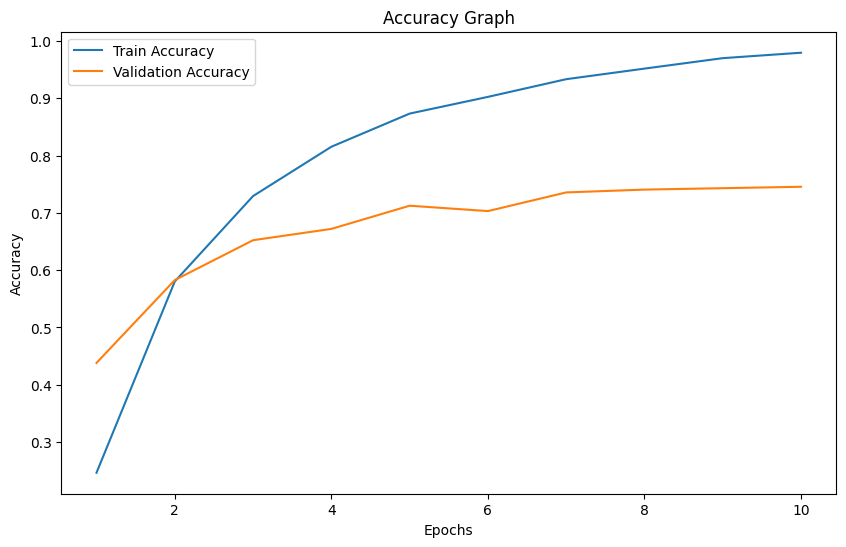

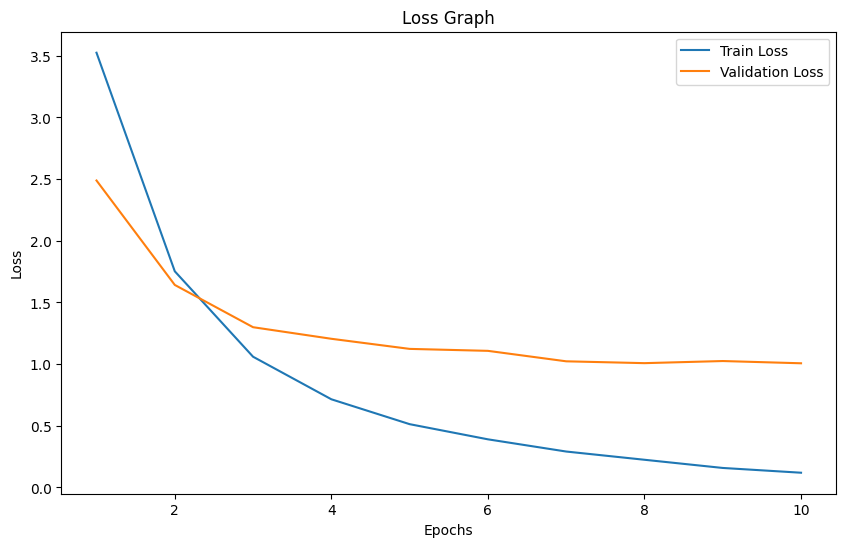

In [85]:
# Extract the training accuracy, validation accuracy, and loss values for each epoch
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show()

# Plot the cross-entropy graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [86]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

64/64 [==============================] - 0s 2ms/step - loss: 0.9819 - accuracy: 0.7461
Test Loss: 0.9818530082702637
Test Accuracy: 0.74609375
